In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [12]:
# Step 1: Generate concentric circles dataset
def generate_circles_data(n_samples=500, noise=0.1, random_seed=42):
    np.random.seed(random_seed)
    n_half = n_samples // 2
    
    # Inner circle (class -1)
    radius_inner = np.random.uniform(0, 0.5, n_half)
    angle_inner = np.random.uniform(0, 2 * np.pi, n_half)
    X_inner = np.column_stack((radius_inner * np.cos(angle_inner),
                               radius_inner * np.sin(angle_inner)))
    y_inner = -np.ones(n_half)
    
    # Outer ring (class +1)
    radius_outer = np.random.uniform(0.8, 1.2, n_half)
    angle_outer = np.random.uniform(0, 2 * np.pi, n_half)
    X_outer = np.column_stack((radius_outer * np.cos(angle_outer),
                               radius_outer * np.sin(angle_outer)))
    X_outer += noise * np.random.randn(n_half, 2)
    y_outer = np.ones(n_half)
    
    X = np.vstack((X_inner, X_outer))
    y = np.hstack((y_inner, y_outer))
    return X, y

X, y = generate_circles_data()

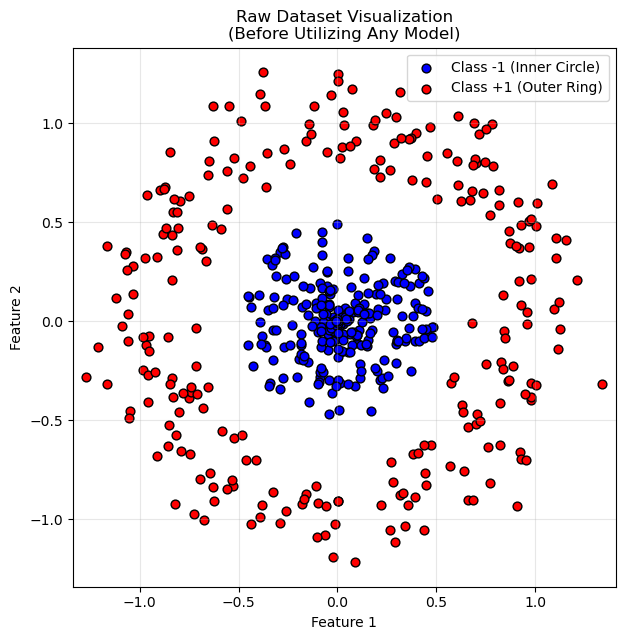

Raw data plot displayed above — observe the clear non-linear (circular) separation needed.


In [13]:
# Step 2: Plot raw data BEFORE any modeling
plt.figure(figsize=(7, 7))
plt.scatter(X[y == -1, 0], X[y == -1, 1], c='blue', label='Class -1 (Inner Circle)', edgecolor='k', s=40)
plt.scatter(X[y == 1, 0], X[y == 1, 1], c='red', label='Class +1 (Outer Ring)', edgecolor='k', s=40)
plt.title('Raw Dataset Visualization\n(Before Utilizing Any Model)')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.axis('equal')
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)
plt.show()
print("Raw data plot displayed above — observe the clear non-linear (circular) separation needed.")

In [7]:
# Step 2: Define kernel functions
# Why: These implement the kernel trick without explicit mapping
def linear_kernel(X1, X2):
    return np.dot(X1, X2.T)

In [ ]:
def polynomial_kernel(X1, X2, degree=3, coef0=1):
    return (np.dot(X1, X2.T) + coef0) ** degree

In [ ]:
def rbf_kernel(X1, X2, gamma=5.0):
    sq_dists = np.sum(X1**2, axis=1)[:, np.newaxis] + \
               np.sum(X2**2, axis=1)[np.newaxis, :] - \
               2 * np.dot(X1, X2.T)
    return np.exp(-gamma * sq_dists)

In [14]:
# Step 3: Generalized Simple SVM class (works with any kernel)
class SimpleKernelSVM:
    def __init__(self, kernel='rbf', C=10.0, gamma=5.0, degree=3, coef0=1, tol=1e-3, max_iter=500):
        self.kernel_name = kernel
        self.C = C
        self.gamma = gamma
        self.degree = degree
        self.coef0 = coef0
        self.tol = tol
        self.max_iter = max_iter
    
    def _kernel(self, X1, X2):
        if self.kernel_name == 'linear':
            return linear_kernel(X1, X2)
        elif self.kernel_name == 'poly':
            return polynomial_kernel(X1, X2, self.degree, self.coef0)
        elif self.kernel_name == 'rbf':
            return rbf_kernel(X1, X2, self.gamma)
    
    def fit(self, X, y):
        n = X.shape[0]
        self.X = X
        self.y = y
        K = self._kernel(X, X)
        
        alphas = np.zeros(n)
        
        for _ in range(self.max_iter):
            prev_alphas = alphas.copy()
            for i in range(n):
                f_i = np.sum(alphas * y * K[:, i])
                if hasattr(self, 'b'):
                    f_i += self.b
                E_i = f_i - y[i]
                
                if (y[i] * E_i < -self.tol and alphas[i] < self.C) or \
                   (y[i] * E_i > self.tol and alphas[i] > 0):
                    eta = K[i,i]
                    if eta > 1e-8:
                        delta = y[i] * E_i / eta
                        alphas[i] = np.clip(alphas[i] - delta, 0, self.C)
            
            # Enforce zero-sum constraint
            violation = np.dot(alphas, y)
            if abs(violation) > 1e-5:
                alphas -= violation * y / n
                alphas = np.clip(alphas, 0, self.C)
            
            if np.linalg.norm(alphas - prev_alphas) < self.tol:
                break
        
        sv = alphas > 1e-5
        if np.any(sv):
            self.b = np.mean(y[sv] - np.dot((alphas[sv] * y[sv]), K[sv][:, sv]))
        else:
            self.b = 0
        
        self.alphas = alphas
        self.sv_idx = sv
        self.support_vectors = X[sv]
        self.sv_y = y[sv]
        self.sv_alphas = alphas[sv]
    
    def decision_function(self, X_test):
        K_test = self._kernel(X_test, self.support_vectors)
        return np.dot(self.sv_alphas * self.sv_y, K_test.T) + self.b
    
    def predict(self, X_test):
        return np.sign(self.decision_function(X_test))
    
    def accuracy(self, X_test, y_test):
        return np.mean(self.predict(X_test) == y_test)


In [15]:
# Step 4: Train three models with different kernels
models = [
    ('Linear', SimpleKernelSVM(kernel='linear', C=10.0)),
    ('Polynomial (deg=3)', SimpleKernelSVM(kernel='poly', degree=3, C=10.0)),
    ('RBF (γ=5)', SimpleKernelSVM(kernel='rbf', gamma=5.0, C=10.0))
]

trained_models = []
accuracies = []

for name, svm in models:
    svm.fit(X, y)
    acc = svm.accuracy(X, y)
    trained_models.append((name, svm))
    accuracies.append(acc)
    print(f"{name} - Training Accuracy: {acc:.3f}, Support Vectors: {np.sum(svm.sv_idx)}")


Linear - Training Accuracy: 0.562, Support Vectors: 495
Polynomial (deg=3) - Training Accuracy: 0.762, Support Vectors: 264
RBF (γ=5) - Training Accuracy: 0.910, Support Vectors: 278


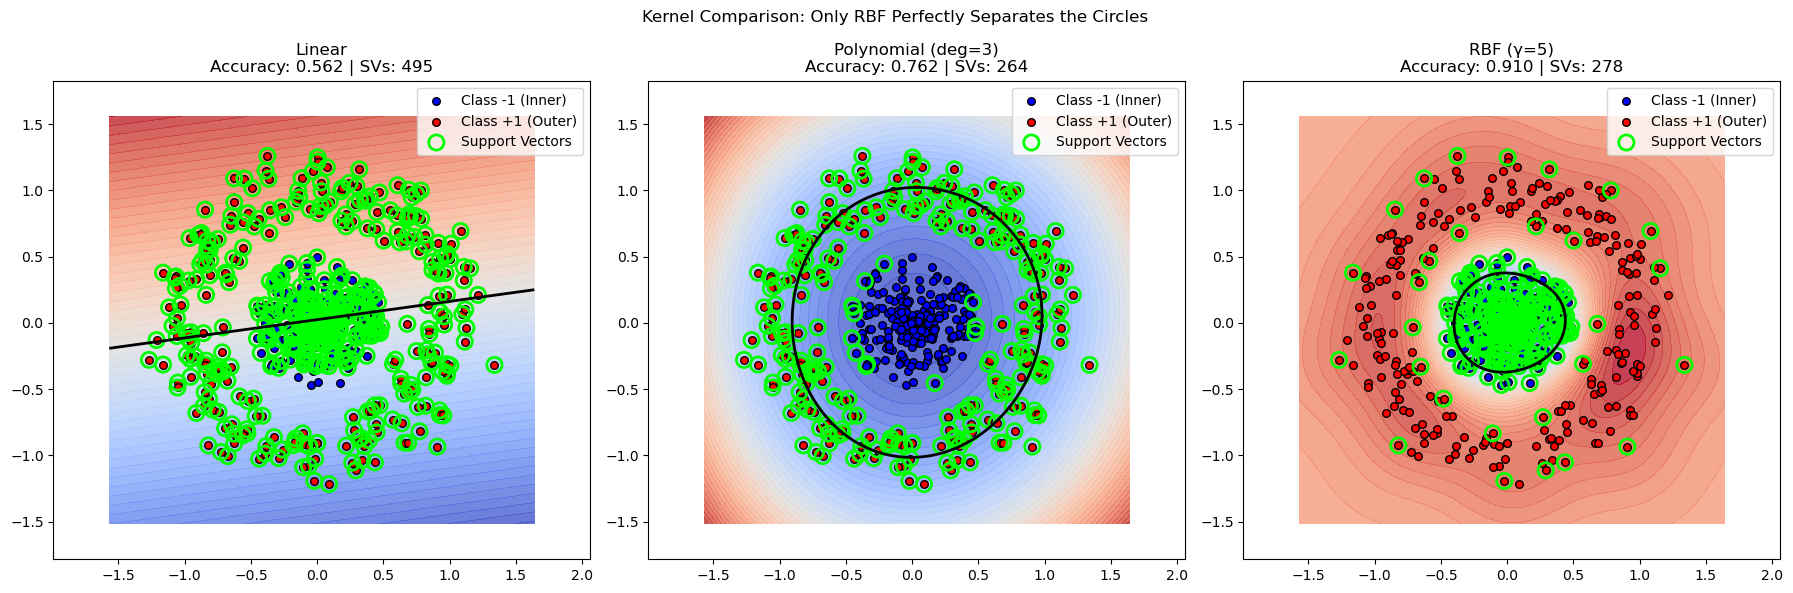

In [16]:
# Step 5: Plot all decision boundaries in one figure (side-by-side)
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
margin = 0.3
xx, yy = np.meshgrid(np.linspace(X[:,0].min()-margin, X[:,0].max()+margin, 200),
                     np.linspace(X[:,1].min()-margin, X[:,1].max()+margin, 200))
grid = np.c_[xx.ravel(), yy.ravel()]

for ax, (name, svm), acc in zip(axes, trained_models, accuracies):
    Z = svm.decision_function(grid).reshape(xx.shape)
    
    # Background contour
    ax.contourf(xx, yy, Z, levels=50, cmap='coolwarm', alpha=0.8)
    # Decision boundary (black line at 0)
    ax.contour(xx, yy, Z, levels=[0], colors='black', linewidths=2)
    
    # Data points
    ax.scatter(X[y==-1,0], X[y==-1,1], c='blue', label='Class -1 (Inner)', edgecolor='k', s=30)
    ax.scatter(X[y==1,0], X[y==1,1], c='red', label='Class +1 (Outer)', edgecolor='k', s=30)
    
    # Highlight support vectors
    sv = svm.support_vectors
    ax.scatter(sv[:,0], sv[:,1], s=120, facecolors='none', edgecolors='lime', linewidths=2, label='Support Vectors')
    
    ax.set_title(f"{name}\nAccuracy: {acc:.3f} | SVs: {len(sv)}")
    ax.axis('equal')
    ax.legend(loc='upper right')

plt.suptitle("Kernel Comparison: Only RBF Perfectly Separates the Circles")
plt.tight_layout()
plt.show()